In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import RestrictedActionsMazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.maze_tree_policy_renderer import render_tree_policy
from mlrl.maze.manhattan_q import ManhattanQHat, InadmissableManhattanQHat

import tensorflow as tf
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment

from pathlib import Path
import json
import yaml

pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
df = pd.DataFrame([
    {
        'name': path.name,
        **json.loads((path / 'files' / 'wandb-summary.json').read_text()),
        **json.loads((path / 'files' / 'wandb-metadata.json').read_text()),
        **{
            k: v['value']
            for k, v in yaml.load((path / 'files' / 'config.yaml').open(), yaml.loader.SafeLoader).items()
            if isinstance(v, dict) and 'value' in v
        },
    }
    for path in Path('wandb').glob('*')
    if path.is_dir() and (path / 'files' / 'wandb-summary.json').exists()
])

In [3]:
from mlrl.experiments.ppo_maze import create_batched_maze_meta_envs, get_maze_name, parse_args
from mlrl.experiments.experiment_utils import create_parser
from mlrl.experiments.ppo_runner import PPORunner

In [4]:
parser = create_parser()
args = vars(parser.parse_known_args()[0])

In [5]:
env, eval_env, video_env = create_batched_maze_meta_envs(**args)
ppo_runner = PPORunner(
    env, eval_env=eval_env, video_env=video_env,
    name=get_maze_name(args), **args
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/usr/local/lib/python3.8/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/usr/local/lib/python3.8/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("E

In [6]:
meta_env0 = video_env.envs[0].gym.env
meta_env1 = video_env.envs[1].gym.env

In [7]:
policy_path = 'outputs/runs/ppo_run_10-55-23-20-01-2023/10-55-23-20-01-2023/policies/'

In [8]:
# policy = tf.saved_model.load(policy_path + 'collect_policy')
# ts = ppo_runner.eval_env.current_time_step()
# policy.action(ts)

In [9]:
from mlrl.experiments.eval_runner import EvalRunner

In [10]:
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy
from mlrl.meta.meta_policies.a_star_policy import get_a_star_action

In [11]:
from mlrl.utils.render_utils import create_and_save_policy_eval_video, embed_mp4
embed_mp4(create_and_save_policy_eval_video(AStarPolicy(video_env), video_env, max_steps=60, rewrite_rewards=True))

In [18]:
meta_env1.tree_tokeniser.can_tokenise(meta_env1.tree)

False

In [19]:
n = sum([
    1 for node in meta_env1.tree.node_list
    if meta_env1.tree_tokeniser.include_unexpandable_leaves or not node.is_unexpandable_leaf()
])
n

33

In [20]:
meta_env1.tree_tokeniser.max_tokens

32

In [17]:
get_a_star_action(meta_env, meta_env.get_observation()['action_mask'])

0

In [18]:
a_star_policy = AStarPolicy(video_env)
a_star_policy.action(video_env.current_time_step())

PolicyStep(action=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 0, 23])>, state=(), info=())

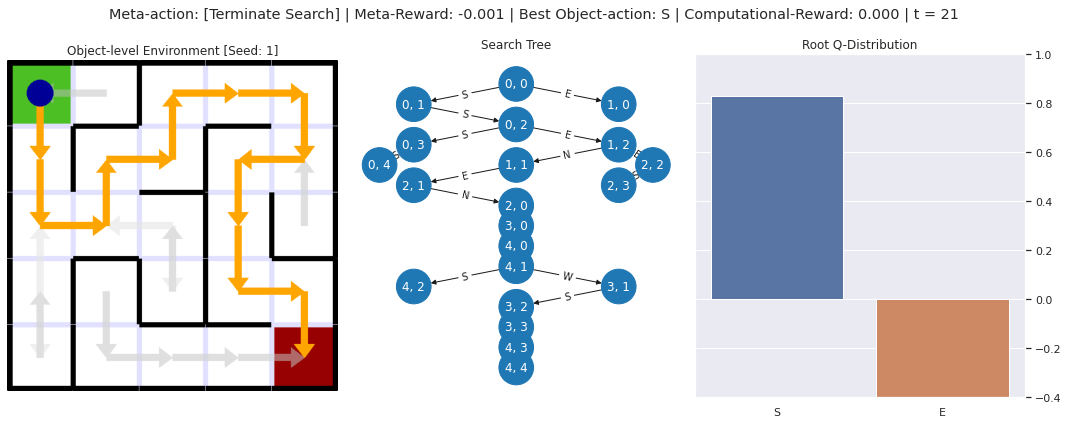

In [13]:
# plt.figure(figsize=(20, 20))
# plt.imshow(meta_env.render(mode='rgb_array'))
# plt.axis('off')
# plt.show()
meta_env.render(plt_show=True);

In [14]:
meta_env.get_observation()

{'search_tree_tokens': array([[ 1.   ,  1.   ,  0.   , ...,  0.   ,  0.   ,  1.   ],
        [ 1.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 1.   ,  0.   , -0.004, ...,  0.   ,  1.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]]),
 'action_mask': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}

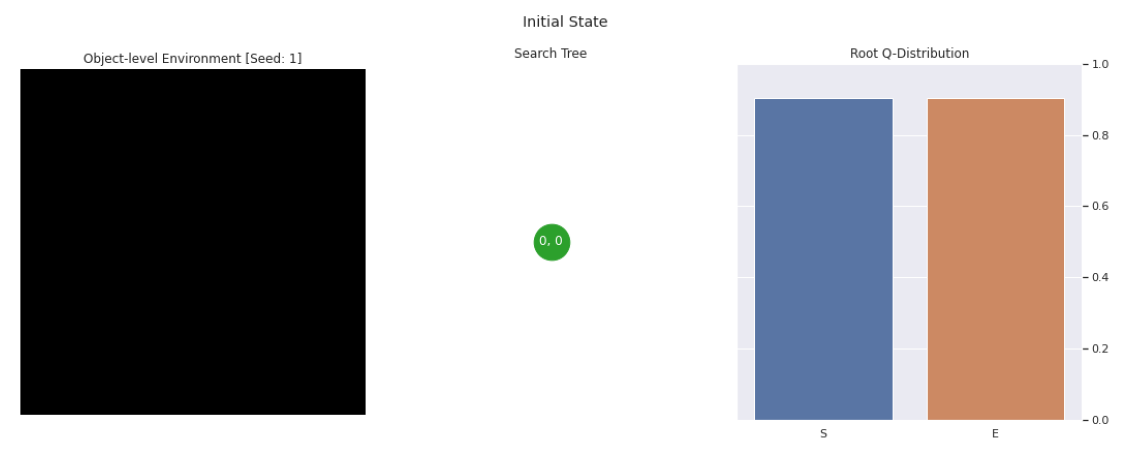

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(meta_env.render(mode='rgb_array'))
plt.axis('off')
plt.show()

In [ ]:
env, eval_env, video_env = create_batched_maze_meta_envs(**{**args, **{'maze_size': 10}})

In [ ]:
from mlrl.utils.render_utils import create_and_save_policy_eval_video, embed_mp4
embed_mp4(create_and_save_policy_eval_video(AStarPolicy(video_env), video_env, max_steps=30, rewrite_rewards=True))

In [ ]:
a_star_policy = AStarPolicy(video_env)

In [ ]:
meta_env = video_env.envs[0].gym.env

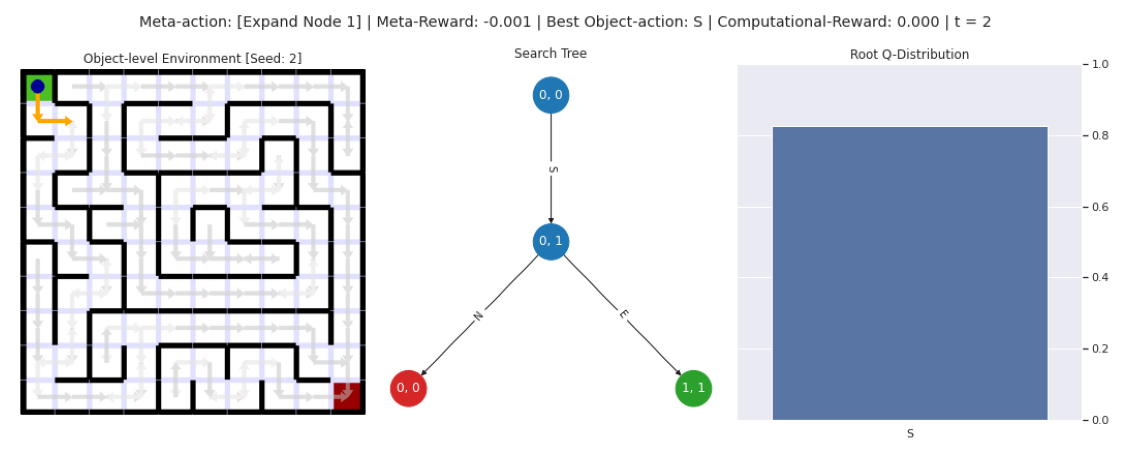

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(meta_env.render(mode='rgb_array'))
plt.axis('off')
plt.show()

18

In [ ]:
a_star_policy.action(video_env.current_time_step()).action[0]

<tf.Tensor: shape=(), dtype=int64, numpy=17>

In [ ]:
meta_env.tree_tokeniser.get_node_idx(meta_env.tree, 17)

29

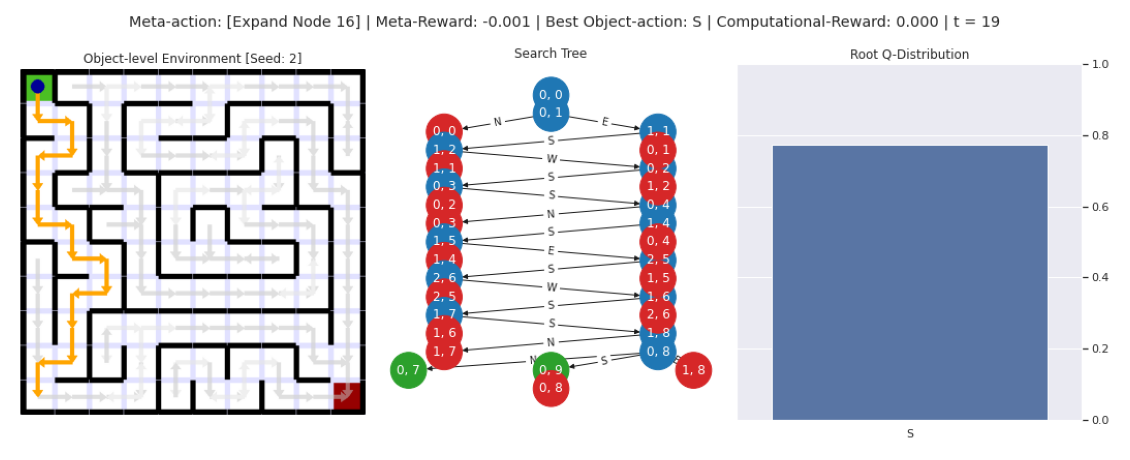

In [ ]:
video_env.step(a_star_policy.action(video_env.current_time_step()).action)
# meta_env.step(3)
plt.figure(figsize=(20, 20))
plt.imshow(meta_env.render(mode='rgb_array'))
plt.axis('off')
plt.show()

In [ ]:
meta_env.tree.node_list[2]

{MazeState(0, 0)}

In [ ]:
a_star_policy.action(video_env.current_time_step()).action

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>

In [ ]:
meta_env.tree

{MazeState(0, 0)}
|---[S, -0.001, 0.827]--> {MazeState(0, 1)}
	|---[N, -0.001, 0.818]--> {MazeState(0, 0)}
	|---[E, -0.001, 0.837]--> (MazeState(1, 1))

In [ ]:
meta_env.get_observation()['action_mask']

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
get_a_star_action(meta_env, meta_env.get_observation()['action_mask'])

3

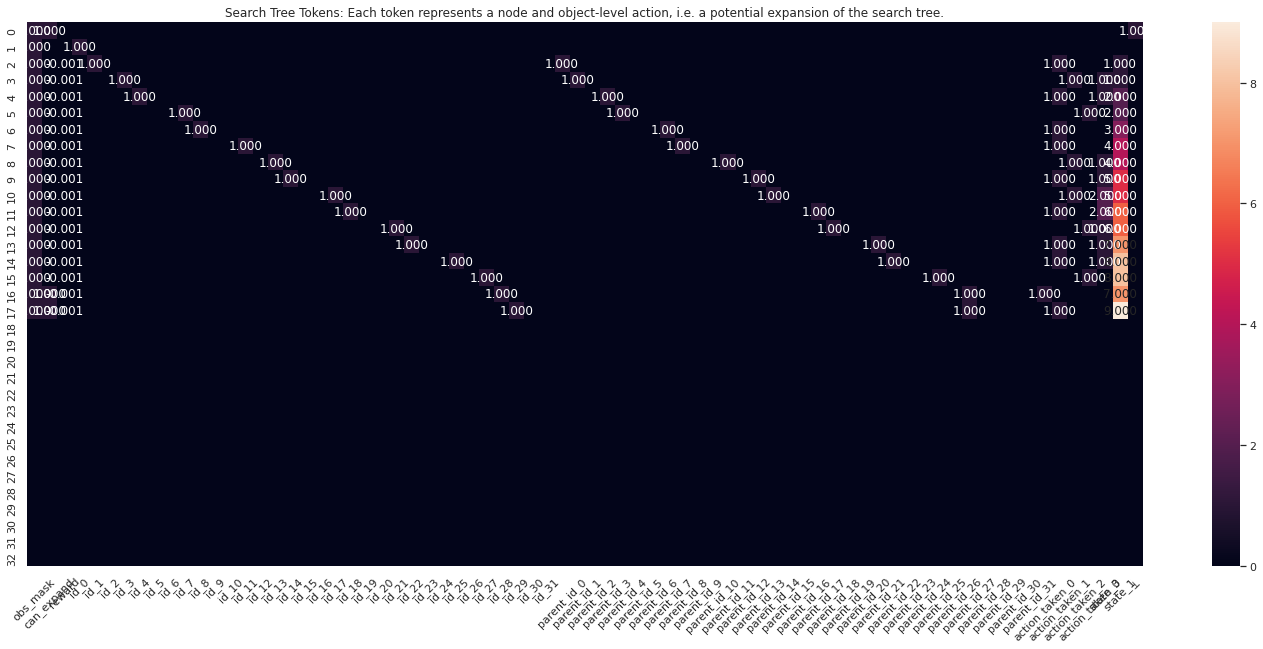

In [ ]:
meta_env.plot_search_tokens()

In [ ]:
print(', '.join(meta_env.get_token_labels()))

obs_mask, can_expand, reward, id_0, id_1, id_2, id_3, id_4, id_5, id_6, id_7, id_8, id_9, id_10, id_11, id_12, id_13, id_14, id_15, id_16, id_17, id_18, id_19, id_20, id_21, id_22, id_23, id_24, id_25, id_26, id_27, id_28, id_29, id_30, id_31, parent_id_0, parent_id_1, parent_id_2, parent_id_3, parent_id_4, parent_id_5, parent_id_6, parent_id_7, parent_id_8, parent_id_9, parent_id_10, parent_id_11, parent_id_12, parent_id_13, parent_id_14, parent_id_15, parent_id_16, parent_id_17, parent_id_18, parent_id_19, parent_id_20, parent_id_21, parent_id_22, parent_id_23, parent_id_24, parent_id_25, parent_id_26, parent_id_27, parent_id_28, parent_id_29, parent_id_30, parent_id_31, action_taken_0, action_taken_1, action_taken_2, action_taken_3, state_0, state_1, $\perp$


In [ ]:
video_env.current_time_step().observation['action_mask']

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [ ]:
embed_mp4(create_and_save_policy_eval_video(policy, video_env, max_steps=30, rewrite_rewards=True))

ValueError: Computational action 0 is not valid.